In [12]:
import datetime
import os
import glob
import gc
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors
import cmcrameri.cm as ccm
plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'

In [13]:
domains = ['d01', 'd02', 'd03', 'd04']
coordsdict = {}
for domain in domains:
    coordsdict[domain] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_{domain}')

In [14]:
params = {'vars': ['prec','t2','snow'],
          'states' : ['CA', 'WY'],
          'res': ['45','9','3']}
res_domain = {'3': ['d03','d04'],
               '9' :['d02'],
               '45':['d01']}
domain_state = {'d01':['CA','WY'],
                'd02':['CA','WY'],
                'd03':['CA'],
                'd04':['WY'],}
boundaries = {'d01':{'CA': [43,60,35,68],
                     'WY': [68,81,43,63]},
              'd02':{'CA': [44,125,87,251],
                     'WY': [165,230,130,227]},
              'd03':{'CA': [0,-1,0,-1]},
              'd04':{'WY': [0,-1,0,-1]}}
state_res_domain = {'CA': {'45':'d01',
                            '9': 'd02',
                            '3':'d03'},
                     'WY': {'45':'d01',
                            '9': 'd02',
                            '3':'d04'},}
gcms_dict = {'d01': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd02': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd03': ['ec-earth3-veg'],
             'd04': ['ec-earth3-veg'],}

bc = 'BC'

In [15]:
partition = np.load('/glade/campaign/uwyo/wyom0112/berkeley/partition_annual.npy',allow_pickle = True).flatten()[0]
alldata = np.load('/glade/campaign/uwyo/wyom0112/berkeley/annual_max_clipped.npy',allow_pickle = True).flatten()[0]

In [16]:
snowmasks = {}
for state in params['states']:
    snowmasks[state] = {}
    for res in params['res']:
        snowdata = alldata['snow'][state][res]['annual_max_clipped']['snow']
        mask = np.nansum(snowdata[0:20], axis = 0) > 400
        snowmasks[state][res] = mask

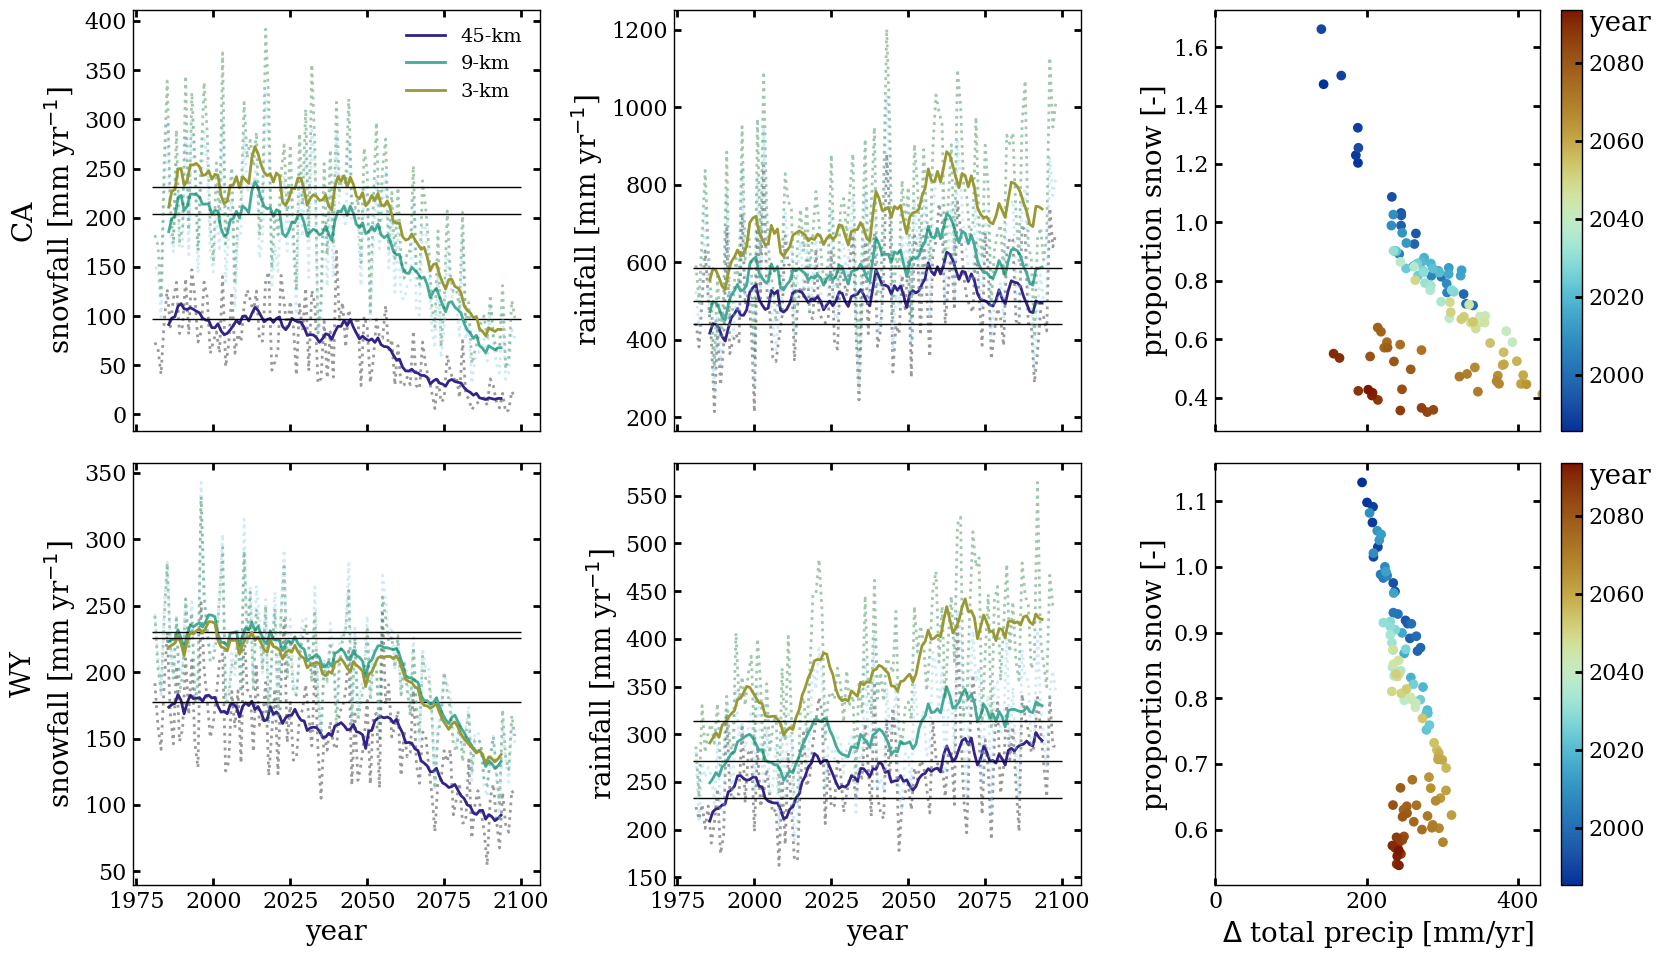

In [17]:
## EC-Earth3-Veg only
ws = 10
var = 'prec'
fig,axs = plt.subplots(2,3, figsize = (17,10))
for i,state in enumerate(params['states']):
    for res in params['res']:
        for j,ptype in enumerate(['snowfall','rainfall']):
            ax = axs[i,j]
            domain = state_res_domain[state][res]
            mask = snowmasks[state][res]
            left, right, bottom, top = boundaries[domain][state]
            tmp = partition[state][res][ptype].sel(lat2d = slice(bottom, top),
                                                                       lon2d = slice(left, right))['prec']
            data = np.nanmean(tmp.where(mask), axis = (1,2))[1:-2]
            #data = np.nanmean(tmp, axis = (1,2))[1:-2]
            years = range(1981,2099)
            #years = alldata[var][state][res]['annual_max_state'].time.dt.year[1:-2]
            ax.plot(years, data, linestyle = ':', alpha = 0.4)
            rolling_yearmean = pd.DataFrame(years).rolling(window = ws).mean()
            rolling_mean = pd.DataFrame(data).rolling(window=ws).mean()
            ax.plot(rolling_yearmean,rolling_mean, label = f'{res}-km')
            ax.hlines(np.nanmean(data[0:20]), 1980, 2100, linewidth = 1)
            ax.set_ylabel(f'{ptype}'+r' [mm yr$^{-1}$]')
            if i == 0: 
                ax.set_xticklabels([])
            if j == 0: ax.set_ylabel(f'{state}\n{ptype}'+r' [mm yr$^{-1}$]')
            if i == 1: ax.set_xlabel('year')
                

    

    j = 2
    ax = axs[i,j]
    domain = state_res_domain[state][res]
    mask = snowmasks[state][res]
    left, right, bottom, top = boundaries[domain][state]
    tmpsnow = partition[state][res]['snowfall'].sel(lat2d = slice(bottom, top),
                                                               lon2d = slice(left, right))['prec']
    tmprain = partition[state][res]['rainfall'].sel(lat2d = slice(bottom, top),
                                                           lon2d = slice(left, right))['prec']
    
    #snowdata = np.nanmean(tmpsnow, axis = (1,2))[1:-2]
    #raindata = np.nanmean(tmprain, axis = (1,2))[1:-2]

    snowdata = np.nanmean(tmpsnow.where(mask), axis = (1,2))[1:-2]
    raindata = np.nanmean(tmprain.where(mask), axis = (1,2))[1:-2]
    raindata = raindata - np.nanmean(raindata[0:30])
    #years = alldata[var][state][res]['annual_max_state'].time.dt.year[1:-2]
    years = range(1981,2099)
    rollyears = pd.DataFrame(years).rolling(window = ws).mean()[0].values
    rollsnow = pd.DataFrame(snowdata).rolling(window = ws).mean()[0].values
    rollrain = pd.DataFrame(raindata).rolling(window = ws).mean()[0].values
    #ax.stackplot(years, snowdata,raindata)
    # ax.plot(years, rollsnow / (rollsnow + rollrain))
    #ax.plot(years, rollrain)
    #ax.twinx().plot(years, rollsnow + rollrain)
    cb = ax.scatter(rollsnow + rollrain, rollsnow / (rollsnow + rollrain), c = rollyears, cmap = ccm.roma_r)
    cbar = plt.colorbar(cb)
    cbar.set_label('year', rotation = 0, loc= 'top')
    ax.set_ylabel('proportion snow [-]')
    # ax.stackplot(rollyears, rollsnow, rollrain)
    #ax.set_ylabel('snowfall [mm]')
    ax.set_xlim((0,430))
axs[0,2].set_xticklabels([])
axs[0,0].legend(loc = 'upper right')

ax.set_xlabel (r'$\Delta$ total precip [mm/yr]')
plt.tight_layout()

plt.show()

In [ ]:
## only 9 and 45 km data

ws = 10
fig,axs = plt.subplots(2,3, figsize = (17,10))
for i,state in enumerate(params['states']):
    for res in params['res']:
        for j,ptype in enumerate(['snowfall','rainfall']):
            ax = axs[i,j]
            domain = state_res_domain[state][res]
            mask = snowmasks[state][res]
            left, right, bottom, top = boundaries[domain][state]
            tmp = partition[state][res][ptype].sel(lat2d = slice(bottom, top),
                                                                       lon2d = slice(left, right))['prec']
            data = np.nanmean(tmp.where(mask), axis = (1,2))[1:-2]
            #data = np.nanmean(tmp, axis = (1,2))[1:-2]
            years = range(1981,2099)
            #years = alldata[var][state][res]['annual_max_state'].time.dt.year[1:-2]
            ax.plot(years, data, linestyle = ':', alpha = 0.4)
            rolling_yearmean = pd.DataFrame(years).rolling(window = ws).mean()
            rolling_mean = pd.DataFrame(data).rolling(window=ws).mean()
            ax.plot(rolling_yearmean,rolling_mean, label = f'{res}-km')
            ax.hlines(np.nanmean(data[0:20]), 1980, 2100, linewidth = 1)
            ax.set_ylabel(f'{ptype}'+r' [mm yr$^{-1}$]')
            if i == 0: 
                ax.set_xticklabels([])
            if j == 0: ax.set_ylabel(f'{state}\n{ptype}'+r' [mm yr$^{-1}$]')
            if i == 1: ax.set_xlabel('year')
                

    

    j = 2
    ax = axs[i,j]
    domain = state_res_domain[state][res]
    mask = snowmasks[state][res]
    left, right, bottom, top = boundaries[domain][state]
    tmpsnow = partition[state][res]['snowfall'].sel(lat2d = slice(bottom, top),
                                                               lon2d = slice(left, right))['prec']
    tmprain = partition[state][res]['rainfall'].sel(lat2d = slice(bottom, top),
                                                           lon2d = slice(left, right))['prec']
    
    #snowdata = np.nanmean(tmpsnow, axis = (1,2))[1:-2]
    #raindata = np.nanmean(tmprain, axis = (1,2))[1:-2]

    snowdata = np.nanmean(tmpsnow.where(mask), axis = (1,2))[1:-2]
    raindata = np.nanmean(tmprain.where(mask), axis = (1,2))[1:-2]
    raindata = raindata - np.nanmean(raindata[0:30])
    #years = alldata[var][state][res]['annual_max_state'].time.dt.year[1:-2]
    years = range(1981,2099)
    rollyears = pd.DataFrame(years).rolling(window = ws).mean()[0].values
    rollsnow = pd.DataFrame(snowdata).rolling(window = ws).mean()[0].values
    rollrain = pd.DataFrame(raindata).rolling(window = ws).mean()[0].values
    #ax.stackplot(years, snowdata,raindata)
    # ax.plot(years, rollsnow / (rollsnow + rollrain))
    #ax.plot(years, rollrain)
    #ax.twinx().plot(years, rollsnow + rollrain)
    cb = ax.scatter(rollsnow + rollrain, rollsnow / (rollsnow + rollrain), c = rollyears, cmap = ccm.roma_r)
    cbar = plt.colorbar(cb)
    cbar.set_label('year', rotation = 0, loc= 'top')
    ax.set_ylabel('proportion snow [-]')
    # ax.stackplot(rollyears, rollsnow, rollrain)
    #ax.set_ylabel('snowfall [mm]')
    ax.set_xlim((0,430))
axs[0,2].set_xticklabels([])
axs[0,0].legend(loc = 'upper right')

ax.set_xlabel (r'$\Delta$ total precip [mm/yr]')
plt.tight_layout()

plt.show()